# Task 2

### Integrantes
* Sergio Orellana 221122
* Rodrigo Mansilla 22611
* Ricardo Chuy 221007

El objetivo de esta parte es implementar el pipeline de alineación sin depender de cajas negras. Por ello considere que no deben de usar cv2.findHonography o cv2.RANSAC. Además para este laboratorio necesitara crear su propio dataset, por ello tome 3 fotografías propias de una escena planar (i.e. una pancarta en una pared, un cuadro, o una fachada de edificio lejana) con ángulos y perspectivas drásticamente diferentes.


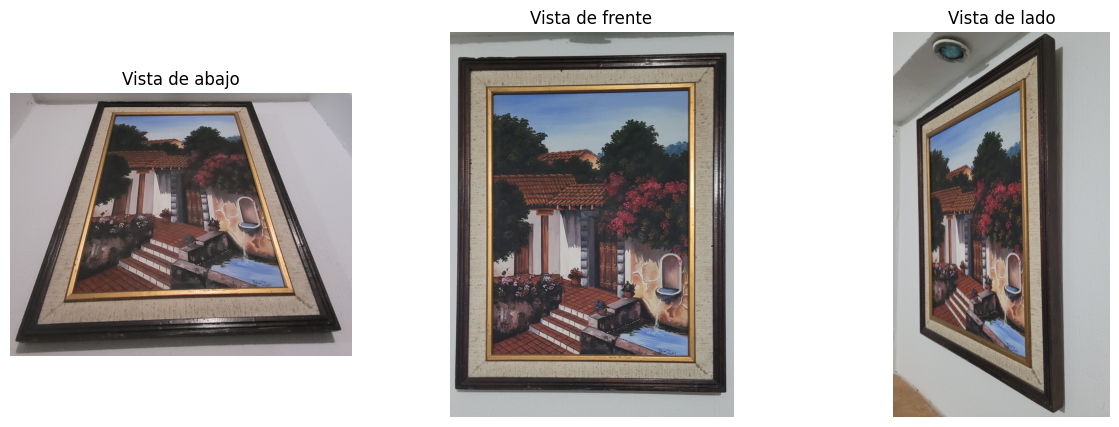

In [47]:
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

img1 = mpimg.imread('imgs/abajo.jpg')
img2 = mpimg.imread('imgs/frente.jpg')
img3 = mpimg.imread('imgs/lado.jpg')
# por algun motivo la imagegn 3 sale horizontalmente, entonces le di vuelta jej
img3 = np.rot90(img3, k=-1)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas

axes[0].imshow(img1)
axes[0].set_title('Vista de abajo')
axes[0].axis('off')  

axes[1].imshow(img2)
axes[1].set_title('Vista de frente')
axes[1].axis('off')

axes[2].imshow(img3)
axes[2].set_title('Vista de lado')
axes[2].axis('off')

# plt.tight_layout()  # Ajustar espaciado
plt.show()

# 1. Detección y Macheo
* a. Utilice SIFT u ORB (permitido usar OpenCV aquí) para detectar puntos de interés y descriptores.
* b. Realice un emparejamiento de fuerza bruta (Brute-Force Matcher).
* c. Requisito: Visualice los matches antes de filtrar. Debe verse una cantidad considerable de ruido/errores

## Parte a

In [ ]:
# parte a


# Rutas a los archivos
PATH_REF = 'imgs/frente.jpg'   # La imagen que es la meta
PATH_OBJ = 'imgs/abajo.jpg'     # La imagen que queremos enderezar

print(f"Referencia: {PATH_REF}\n Objetivo:   {PATH_OBJ}")

# 
img_ref_bgr = cv2.imread(PATH_REF)
img_obj_bgr = cv2.imread(PATH_OBJ)

# Validación simple
if img_ref_bgr is None or img_obj_bgr is None:
    raise ValueError("No se encontro la img")

img_ref_rgb = cv2.cvtColor(img_ref_bgr, cv2.COLOR_BGR2RGB)
img_obj_rgb = cv2.cvtColor(img_obj_bgr, cv2.COLOR_BGR2RGB)

img_ref_gray = cv2.cvtColor(img_ref_bgr, cv2.COLOR_BGR2GRAY)
img_obj_gray = cv2.cvtColor(img_obj_bgr, cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()

# los keypoints y descriptores
kp_ref, des_ref = sift.detectAndCompute(img_ref_gray, None)
kp_obj, des_obj = sift.detectAndCompute(img_obj_gray, None)

print(f"Keypoints en Referencia: {len(kp_ref)}")
print(f"Keypoints en Objetivo:   {len(kp_obj)}")



Referencia: imgs/frente.jpg
 Objetivo:   imgs/abajo.jpg
Keypoints en Referencia: 28311
Keypoints en Objetivo:   10239


## Parte b

In [49]:
# Usamos Fuerza Bruta con distancia Euclidiana, el k=2 igual que en el lab pasado significa
# los 2 mejores matches
matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches_crudos = matcher.knnMatch(des_ref, des_obj, k=2)

print(f"Matches Totales: {len(matches_crudos)}")

Matches Totales: 28311


## Parte c

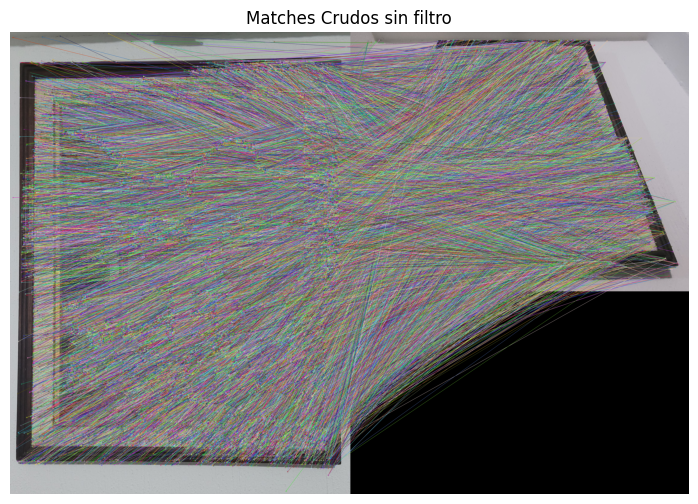

In [50]:
matches_sin_filtro = [m for m, n in matches_crudos]

# Flags=0 dibuja todo. Flags=2 no dibuja puntos huerfanos.
img_ruido = cv2.drawMatches(
    img_ref_rgb, kp_ref, 
    img_obj_rgb, kp_obj, 
    matches_sin_filtro, # Pasamos la muestra ruidosa
    None, 
    flags=2
)

plt.figure(figsize=(15, 6))
plt.title("Matches Crudos sin filtro")
plt.imshow(img_ruido)
plt.axis('off')
plt.show()

Con este resultado queda en evidencia que realmente hacer un match con una imagen sin un filtro es muy poco preciso ya que muchos puntos al final se marcan como coincidencia. SIFT aunque es una herramienta 

Matches Totales: 28311
Matches Buenos: 1102


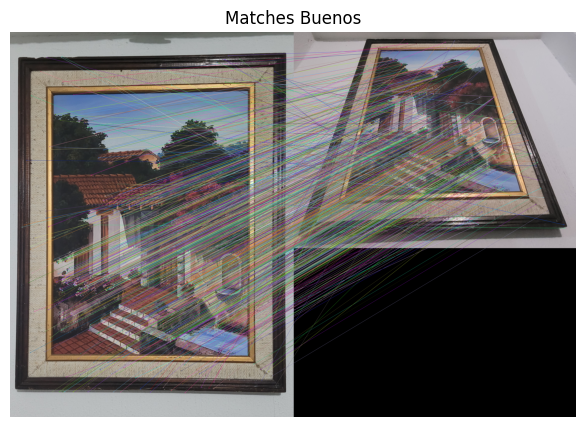

In [51]:
# esto es algo extra que quisimos poner para verificar el match con filtro como el lab pasado

ratio = 0.75
matches_buenos = []

for m, n in matches_crudos:
    if m.distance < ratio * n.distance:
        matches_buenos.append(m)

print(f"Matches Totales: {len(matches_crudos)}")
print(f"Matches Buenos: {len(matches_buenos)}")

# visualizacion de los matches
img_matches = cv2.drawMatches(img_ref_rgb, kp_ref, img_obj_rgb, kp_obj, matches_buenos, None, flags=2)
plt.figure(figsize=(15, 5))
plt.title("Matches Buenos")
plt.imshow(img_matches)
plt.axis('off')
plt.show()


# 2.Algoritmo DLT
* a. Escriba una función calcular_homografia_dlt(puntos_src, puntos_dst) que reciba exactamente 4 pares de puntos.
* b. Debe construir la matriz A de tamaño 8×9.
* c. Debe resolver el sistema usando SVD (numpy.linalg.svd).
* d. Nota: Debe normalizar los puntos antes de entrar al DLT (restar la media y dividir por la desviación estándar) para estabilidad numérica, y des-normalizar la matriz H resultante.


## Parte a

In [ ]:
def normalizar_puntos(puntos):

    # calcular la media de X y Y
    media = np.mean(puntos, axis=0)
    mx, my = media[0], media[1]
    
    # la desviación estándar de los puntos
    desviacion_est = np.std(puntos)
    
    # una pequenia verificacion por si hay dificion por 0
    if desviacion_est < 1e-10: desviacion_est = 1.0
    
    # matirz de transformacion T
    # en terminos generales el calculo es x_nuevo = (x_viejo - media) / desviacion_est
    # Esto equivale a: x_nuevo = (1/desviacion_est)*x_viejo - (media/desviacion_est)

    scale = 1.0 / desviacion_est
    
    T = np.array([
        [scale,     0,   -mx * scale],
        [0,     scale,   -my * scale],
        [0,         0,             1]
    ])
 
    puntos_h = np.column_stack((puntos, np.ones(len(puntos))))
    
    # Multiplicar: (T @ puntos)^Transpuesta
    # T es 3x3, puntos_h.T es 3xN entonces el resultado es 3xN y se transpone a Nx3
    puntos_norm = (T @ puntos_h.T).T
    
    # se retornan las coordenadas cartesianas y la matriz T
    return puntos_norm[:, :2], T

In [ ]:
def calcular_homografia_dlt(puntos_src, puntos_dst):

    # esto es para restriginr, ya que se necesitan 4 puntos
    if len(puntos_src) != 4 or len(puntos_dst) != 4:
        raise ValueError("DLT requiere exactamente 4 pares de puntos.")

    # lo primero es normalizar puntos, osea el inciso d
    src_norm, T_src = normalizar_puntos(puntos_src)
    dst_norm, T_dst = normalizar_puntos(puntos_dst)
    
    # Construir la matriz A, osea el inciso b, la matriz de 8x9
    # Tamaño esperado: 8x9
    A = []
    
    for i in range(4):
        x, y = src_norm[i]
        xp, yp = dst_norm[i] 
        
        # Dos filas por cada punto
        A.append([-x, -y, -1, 0, 0, 0, x*xp, y*xp, xp])
        
        A.append([0, 0, 0, -x, -y, -1, x*yp, y*yp, yp])
        
    A = np.array(A)
    
    # Resolver sistema usando SVD, inciso c
    U, S, Vt = np.linalg.svd(A)
    
    # La solución es la última fila de Vt
    L = Vt[-1]
    
    # Reconstruir matriz H que es de 3x3
    H_norm = L.reshape(3, 3)
    
    # Des-normalizar H, inciso d otra vez
    # esto de aca abajo ses en realidad: H_real = inv(T_dst) * H_norm * T_src
    H = np.linalg.inv(T_dst) @ H_norm @ T_src
    
    # Normalizar H para que el último elemento sea 1
    H = H / H[2, 2]
    
    return H

In [ ]:
puntos_prueba = np.array([
    [1000, 1000], 
    [1050, 1000], 
    [1000, 1050], 
    [1100, 1100]
], dtype=float)

print("Antes de norm")
print(f"Media: {np.mean(puntos_prueba, axis=0)}")
print(f"Desviación Estándar: {np.std(puntos_prueba):.4f}")
print("Puntos:\n", puntos_prueba)

# aplcar funcion para probar
puntos_norm, T = normalizar_puntos(puntos_prueba)

print("\nDespues de norma")
print(f"Media. Aprox 0: {np.mean(puntos_norm, axis=0)}")
print(f"Desviación Estándar. Aprox 1: {np.std(puntos_norm):.4f}")
print("Puntos Normalizados:\n", np.round(puntos_norm, 4))

print("\nMatriz de ejelmpo")
print(T)

Antes de norm
Media: [1037.5 1037.5]
Desviación Estándar: 41.4578
Puntos:
 [[1000. 1000.]
 [1050. 1000.]
 [1000. 1050.]
 [1100. 1100.]]

Despues de norma
Media. Aprox 0: [-1.77635684e-15 -1.77635684e-15]
Desviación Estándar. Aprox 1: 1.0000
Puntos Normalizados:
 [[-0.9045 -0.9045]
 [ 0.3015 -0.9045]
 [-0.9045  0.3015]
 [ 1.5076  1.5076]]

Matriz de ejelmpo
[[ 2.41209076e-02  0.00000000e+00 -2.50254416e+01]
 [ 0.00000000e+00  2.41209076e-02 -2.50254416e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
